## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from tensorflow.keras.models  import Sequential 
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names) # names = column names
diabetes_df

,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5) 

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
760,2,88,58,26,16,28.4,0.766,22,0
144,4,154,62,31,284,32.8,0.237,23,0
340,1,130,70,13,105,25.9,0.472,22,0
660,10,162,84,0,0,27.7,0.182,54,0
70,2,100,66,20,90,32.9,0.867,28,1


In [5]:
X = diabetes_df.iloc[:, :-1].values 
y = diabetes_df["has_diabetes"].values
X, y

(array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
        [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
        [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
        ...,
        [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
        [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
        [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)
# stratetify refer to the proportion of the data in each class

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=seed_value)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=11111)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_rf)))
# Accuracy is 0.771 (77.1%) means, from 100 peoples 77 peoples are correctly predicted
# Medical related field is really sensitive to be using in real life, if we fail once it can be fatal for the patient
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.771
roc-auc is 0.795


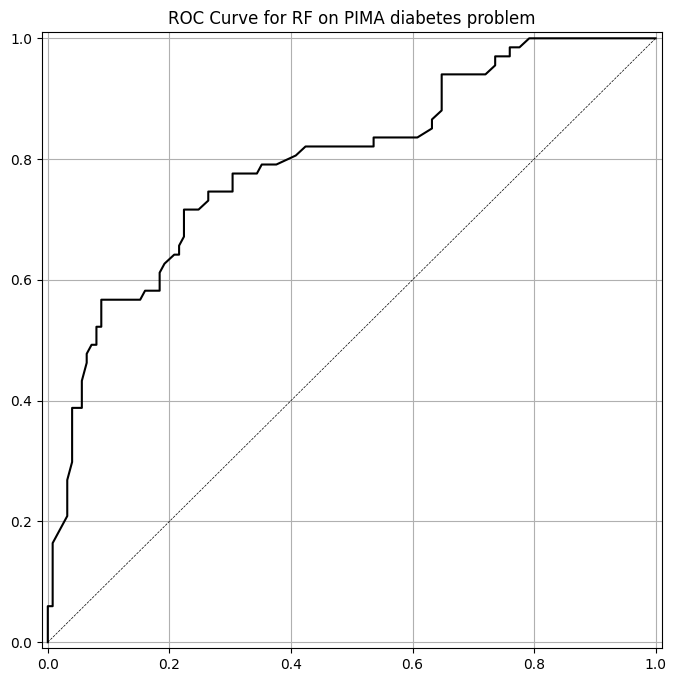

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 8 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train) # fit_transform learns the mean and std dev, and then applies them to the data
X_test_norm = normalizer.transform(X_test) # transform applies the mean and std dev

In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 8 hidden nodes, ReLU activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

import os, random, numpy as np
import tensorflow as tf 

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

model_1 = Sequential([
    Dense(8, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Comprehension question:
Why do we have 81 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [14]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200, batch_size=32)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/200
18/18 [==============================] - 0s 4ms/step - loss: 0.7662 - accuracy: 0.4688 - val_loss: 0.7449 - val_accuracy: 0.5104
Epoch 2/200
18/18 [==============================] - 0s 950us/step - loss: 0.7588 - accuracy: 0.4774 - val_loss: 0.7373 - val_accuracy: 0.5156
Epoch 3/200
18/18 [==============================] - 0s 891us/step - loss: 0.7518 - accuracy: 0.4861 - val_loss: 0.7302 - val_accuracy: 0.5312
Epoch 4/200
18/18 [==============================] - 0s 881us/step - loss: 0.7452 - accuracy: 0.5035 - val_loss: 0.7234 - val_accuracy: 0.5625
Epoch 5/200
18/18 [==============================] - 0s 915us/step - loss: 0.7391 - accuracy: 0.5191 - val_loss: 0.7171 - val_accuracy: 0.5677
Epoch 6/200
18/18 [==============================] - 0s 852us/step - loss: 0.7332 - accuracy: 0.5295 - val_loss: 0.7113 - val_accuracy: 0.5781
Epoch 7/200
18/18 [==============================] - 0s 862us/step - loss: 0.7278 - accuracy: 0.5434 - val_loss: 0.7057 - val_accuracy: 0.6042
E

In [15]:
#  Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilistic score.
#  hard decision : prediction of the model
#  probabilistic score : probability of the prediction

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 [==============================] - 0s 430us/step


In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [17]:
y_pred_prob_nn_1[:10]

array([[0.58112663],
       [0.32257375],
       [0.6120373 ],
       [0.1330455 ],
       [0.49373558],
       [0.709026  ],
       [0.5599952 ],
       [0.15182671],
       [0.17918727],
       [0.9180581 ]], dtype=float32)

accuracy is 0.729
roc-auc is 0.815


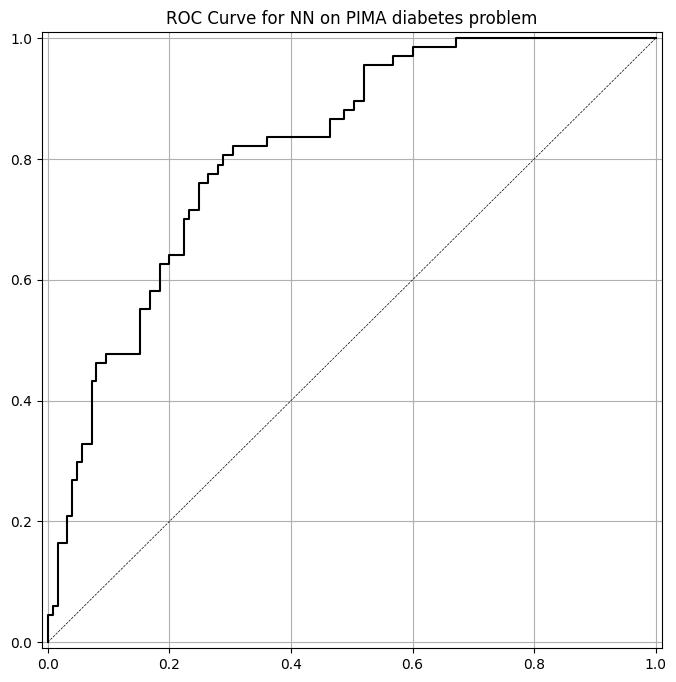

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test, y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

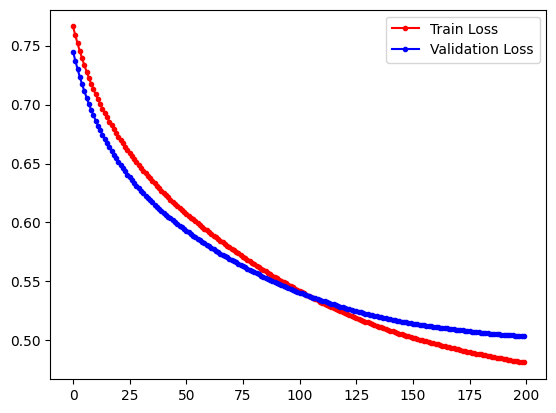

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [111]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(
    X_train_norm, 
    y_train, 
    validation_data=(X_test_norm, y_test), 
    epochs=1000, 
    batch_size=32
)

Epoch 1/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.7969 - val_loss: 0.5136 - val_accuracy: 0.7396
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7969 - val_loss: 0.5136 - val_accuracy: 0.7396
Epoch 3/1000
18/18 [==============================] - 0s 897us/step - loss: 0.4257 - accuracy: 0.7969 - val_loss: 0.5137 - val_accuracy: 0.7396
Epoch 4/1000
18/18 [==============================] - 0s 943us/step - loss: 0.4256 - accuracy: 0.7969 - val_loss: 0.5137 - val_accuracy: 0.7396
Epoch 5/1000
18/18 [==============================] - 0s 896us/step - loss: 0.4256 - accuracy: 0.7969 - val_loss: 0.5137 - val_accuracy: 0.7396
Epoch 6/1000
18/18 [==============================] - 0s 860us/step - loss: 0.4256 - accuracy: 0.7969 - val_loss: 0.5137 - val_accuracy: 0.7396
Epoch 7/1000
18/18 [==============================] - 0s 877us/step - loss: 0.4256 - accuracy: 0.7969 - val_loss: 0.5137 - val_accuracy: 0.7

In [113]:
final_train_loss = run_hist_1b.history["loss"][-1]
final_val_loss = run_hist_1b.history["val_loss"][-1]
final_train_accuracy = run_hist_1b.history["accuracy"][-1]
final_val_accuracy = run_hist_1b.history["val_accuracy"][-1]

print("Final Training Loss: {:.4f}".format(final_train_loss))
print("Final Validation Loss: {:.4f}".format(final_val_loss))
print("Final Training accuracy: {:.4f}".format(final_train_accuracy))
print("Final Validation accuracy: {:.4f}".format(final_val_accuracy))

Final Training Loss: 0.4108
Final Validation Loss: 0.5204
Final Training accuracy: 0.8125
Final Validation accuracy: 0.7500


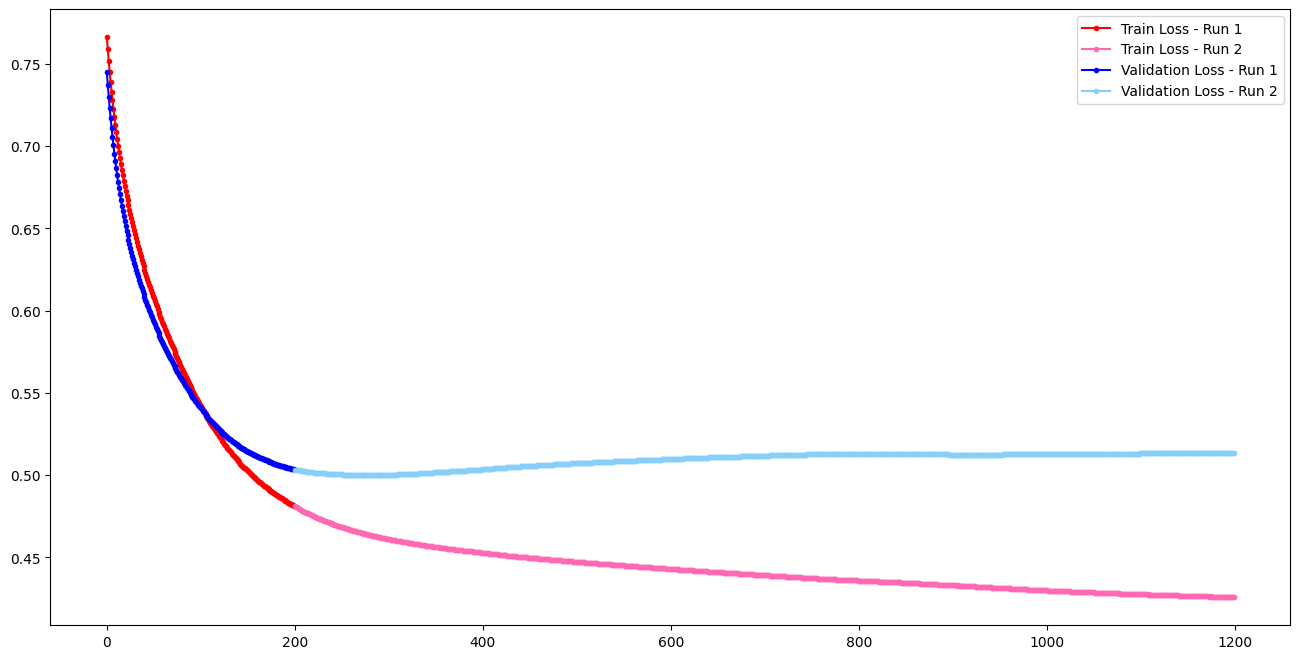

In [88]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

# <span style="color:blue">แบบฝึกปฏิบัติ</span>

(รวม 100 คะแนน) ให้นิสิตใช้พื้นที่ต่อไปนี้ ในการเพิ่มโค้ดให้เป็นไปตามข้อกำหนดต่อไปนี้
1. (50 คะแนน) เพิ่มเซลโค้ด เพื่อ
   * สร้างโมเดลที่มีเลเยอร์ hidden 2 ชั้น แต่ละชั้นมี 6 โหนด
   * ปรับโค้ดให้สามารถรับอินพุตที่มีจำนวน feature ตามข้อมูลเทรนที่จะถูกส่งเข้ามา (ปราศจากการใช้ค่าคงที่ 8 ที่ถูกระบุอยู่ในโค้ด ณ ตอนนี้)
   * สำหรับเลเยอร์ hidden ให้ใช้ activation function เป็น "relu" และเลเยอร์ output เป็น "sigmoid"
   * ใช้ learning rate เท่ากับ 0.003 และเทรนด้วยจำนวน 1500 epochs ส่วนสำหรับ Hyperparameter ที่เหลือให้ใช้ค่าคงเดิม
   * วาดกราฟของค่า loss และ accuracy ด้วยทั้งชุดข้อมูล train และ test (ดังตัวอย่างในรูปนี้)
  <img src="https://drive.google.com/uc?id=1GuN0KQf64rGMa4oCY2upnbOTMzWaXmbT" style="height:360px">

In [89]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names) # names = column names

X = diabetes_df.iloc[:, :-1].values 
y = diabetes_df["has_diabetes"].values

# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)

In [90]:
normalizer = StandardScaler() # scaling the input data

''' Applying the transformation learned from the training data to the test data,
    ensuring that the preprocessing steps are consistent between the two sets '''
X_train_norm = normalizer.fit_transform(X_train) # fit_transform learns the mean and std dev, and then applies them to the data
X_test_norm = normalizer.transform(X_test) # transform applies the mean and std dev

In [91]:
# Define the Model 

import os, random, numpy as np
import tensorflow as tf 

# Ensuring that the results are reproducible
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

# make the input of the model dynamic to the number of features of the dataset
num_features = len(diabetes_df.columns) - 1

# model with 2 hidden layers with 6 nodes each
# relu for hidden layers and sigmoid for output layer
model_2 = Sequential([
    Dense(6, input_shape=(num_features,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])

'''
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 6)                 54 (( 8 + 1 ) * 6 )
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42 (( 6 + 1 ) * 6 )
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7  (( 6 + 1 ) * 1 )
=================================================================
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________

Note : param = ( input units + 1 ) * output units
'''

'\nModel: "sequential"\n_________________________________________________________________\nLayer (type)                 Output Shape              Param #   \n=================================================================\ndense (Dense)                (None, 6)                 54 (( 8 + 1 ) * 6 )\n_________________________________________________________________\ndense_1 (Dense)              (None, 6)                 42 (( 6 + 1 ) * 6 )\n_________________________________________________________________\ndense_2 (Dense)              (None, 1)                 7  (( 6 + 1 ) * 1 )\n=================================================================\nTotal params: 103\nTrainable params: 103\nNon-trainable params: 0\n_________________________________________________________________\n\nNote : param = ( input units + 1 ) * output units\n'

In [92]:
# learning rate fix to 0.003
# 1500 epochs (iterations)

model_2.compile(
    optimizer=SGD(learning_rate=0.003),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

run_hist_2 = model_2.fit(
    X_train_norm,
    y_train,
    validation_data=(X_test_norm, y_test),
    epochs=1500,
    batch_size=32,
)

Epoch 1/1500
18/18 [==============================] - 0s 4ms/step - loss: 0.7849 - accuracy: 0.3490 - val_loss: 0.7797 - val_accuracy: 0.3385
Epoch 2/1500
18/18 [==============================] - 0s 944us/step - loss: 0.7710 - accuracy: 0.3368 - val_loss: 0.7659 - val_accuracy: 0.3281
Epoch 3/1500
18/18 [==============================] - 0s 900us/step - loss: 0.7586 - accuracy: 0.3403 - val_loss: 0.7536 - val_accuracy: 0.3333
Epoch 4/1500
18/18 [==============================] - 0s 912us/step - loss: 0.7475 - accuracy: 0.3351 - val_loss: 0.7424 - val_accuracy: 0.3385
Epoch 5/1500
18/18 [==============================] - 0s 896us/step - loss: 0.7374 - accuracy: 0.3385 - val_loss: 0.7321 - val_accuracy: 0.3646
Epoch 6/1500
18/18 [==============================] - 0s 870us/step - loss: 0.7282 - accuracy: 0.3438 - val_loss: 0.7228 - val_accuracy: 0.4062
Epoch 7/1500
18/18 [==============================] - 0s 848us/step - loss: 0.7199 - accuracy: 0.4028 - val_loss: 0.7143 - val_accuracy: 0

In [93]:
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
y_pred_class_nn_2 = (y_pred_prob_nn_2 >= 0.5).astype('int32')

6/6 [==============================] - 0s 673us/step


In [94]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [105]:
final_train_loss = run_hist_2.history["loss"][-1]
final_val_loss = run_hist_2.history["val_loss"][-1]
final_train_accuracy = run_hist_2.history["accuracy"][-1]
final_val_accuracy = run_hist_2.history["val_accuracy"][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Final Training Loss: 0.4244
Final Validation Loss: 0.5003
Final Training Accuracy: 0.8038
Final Validation Accuracy: 0.7500


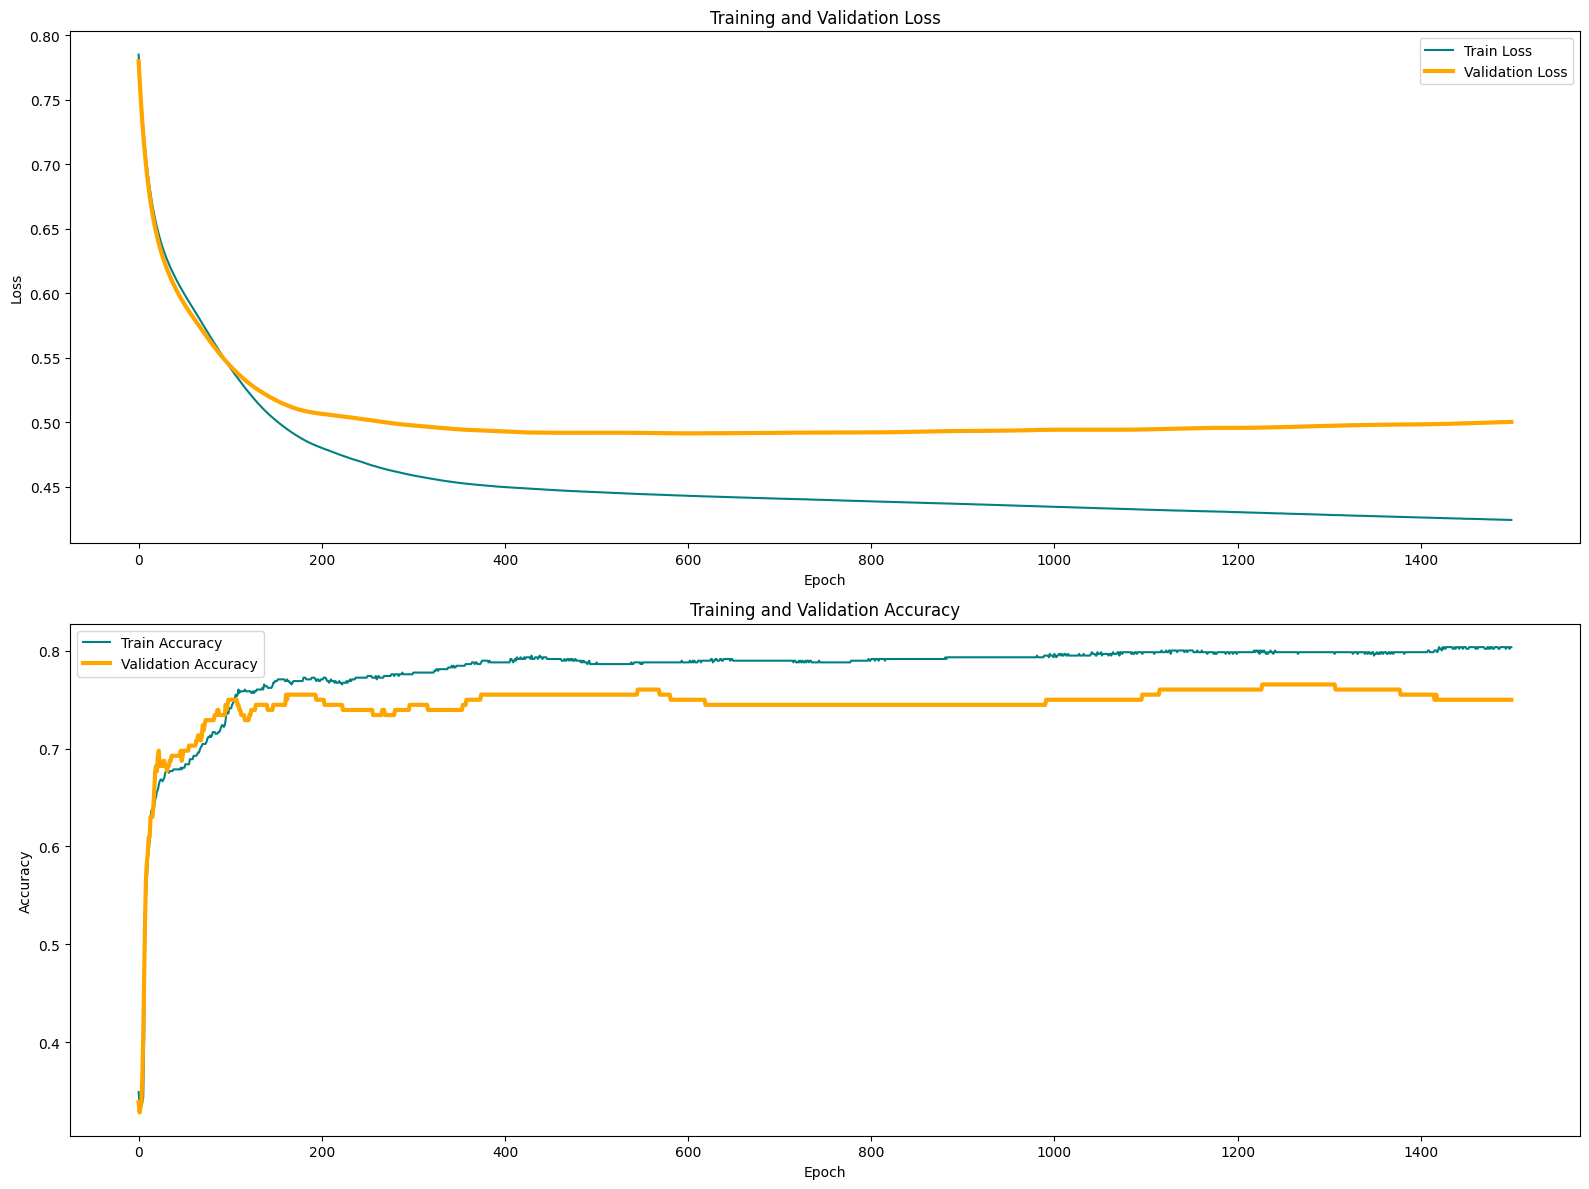

In [143]:
# Plot loss
fig2, (bx1, bx2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
bx1.plot(run_hist_2.history["loss"], 'teal', linestyle='-', label="Train Loss")
bx1.plot(run_hist_2.history["val_loss"], 'orange', linestyle='-', linewidth=3, label="Validation Loss")
bx1.legend()
bx1.set_xlabel("Epoch")
bx1.set_ylabel("Loss")
bx1.set_title("Training and Validation Loss")

# Plot accuracy
bx2.plot(run_hist_2.history["accuracy"], 'teal', linestyle='-', label="Train Accuracy")
bx2.plot(run_hist_2.history["val_accuracy"], 'orange', linestyle='-', linewidth=3, label="Validation Accuracy")
bx2.legend()
bx2.set_xlabel("Epoch")
bx2.set_ylabel("Accuracy")
bx2.set_title("Training and Validation Accuracy")

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()


2. (50 คะแนน) เพิ่มอีกเซลโค้ด เพื่อสร้างโมเดลที่มีการปรับโครงสร้างที่เหมาะสมขึ้น รวมถึงการปรับค่า Hyperparameter ต่าง ๆ เพื่อให้โมเดลใหม่ได้ผลลัพธ์ที่ดีขึ้น (โดยพิจารณาจากค่า accuracy) และในการเทรนโมเดลใหม่นี้ ห้ามมีการใช้ Early Stopping 
   * ให้วาดกราฟของค่า loss และ accuracy ของโมเดลใหม่นี้ด้วย
   * อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม

   Notes :
   - ปรับค่า Hyperparameter ต่าง ๆ
   - ห้ามการ Early Stopping 
   - พิจารณาจากค่า accuracy

In [167]:
model_3 = Sequential([
    Dense(6, input_shape=(num_features,), activation="relu"),
    Dense(6, activation="relu"),
    Dense(6, activation="relu"),
    Dense(1, activation="sigmoid")
])

# learning rate fix to 0.003
# 1500 epochs (iterations)

model_3.compile(
    optimizer=SGD(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

run_hist_3 = model_3.fit(
    X_train_norm,
    y_train,
    validation_data=(X_test_norm, y_test),
    epochs=1000,
    batch_size=16,
)

y_pred_prob_nn_3 = model_3.predict(X_test_norm)
y_pred_class_nn_3 = (y_pred_prob_nn_3 >= 0.5).astype('int32')

final_train_loss = run_hist_3.history["loss"][-1]
final_val_loss = run_hist_3.history["val_loss"][-1]
final_train_accuracy = run_hist_3.history["accuracy"][-1]
final_val_accuracy = run_hist_3.history["val_accuracy"][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

Epoch 1/1000
36/36 [==============================] - 0s 2ms/step - loss: 0.7183 - accuracy: 0.3993 - val_loss: 0.7100 - val_accuracy: 0.4323
Epoch 2/1000
36/36 [==============================] - 0s 681us/step - loss: 0.7139 - accuracy: 0.4115 - val_loss: 0.7062 - val_accuracy: 0.4479
Epoch 3/1000
36/36 [==============================] - 0s 714us/step - loss: 0.7099 - accuracy: 0.4271 - val_loss: 0.7029 - val_accuracy: 0.4844
Epoch 4/1000
36/36 [==============================] - 0s 700us/step - loss: 0.7062 - accuracy: 0.4340 - val_loss: 0.6998 - val_accuracy: 0.4583
Epoch 5/1000
36/36 [==============================] - 0s 653us/step - loss: 0.7029 - accuracy: 0.4531 - val_loss: 0.6969 - val_accuracy: 0.4531
Epoch 6/1000
36/36 [==============================] - 0s 648us/step - loss: 0.6998 - accuracy: 0.4653 - val_loss: 0.6943 - val_accuracy: 0.4792
Epoch 7/1000
36/36 [==============================] - 0s 704us/step - loss: 0.6969 - accuracy: 0.4792 - val_loss: 0.6917 - val_accuracy: 0

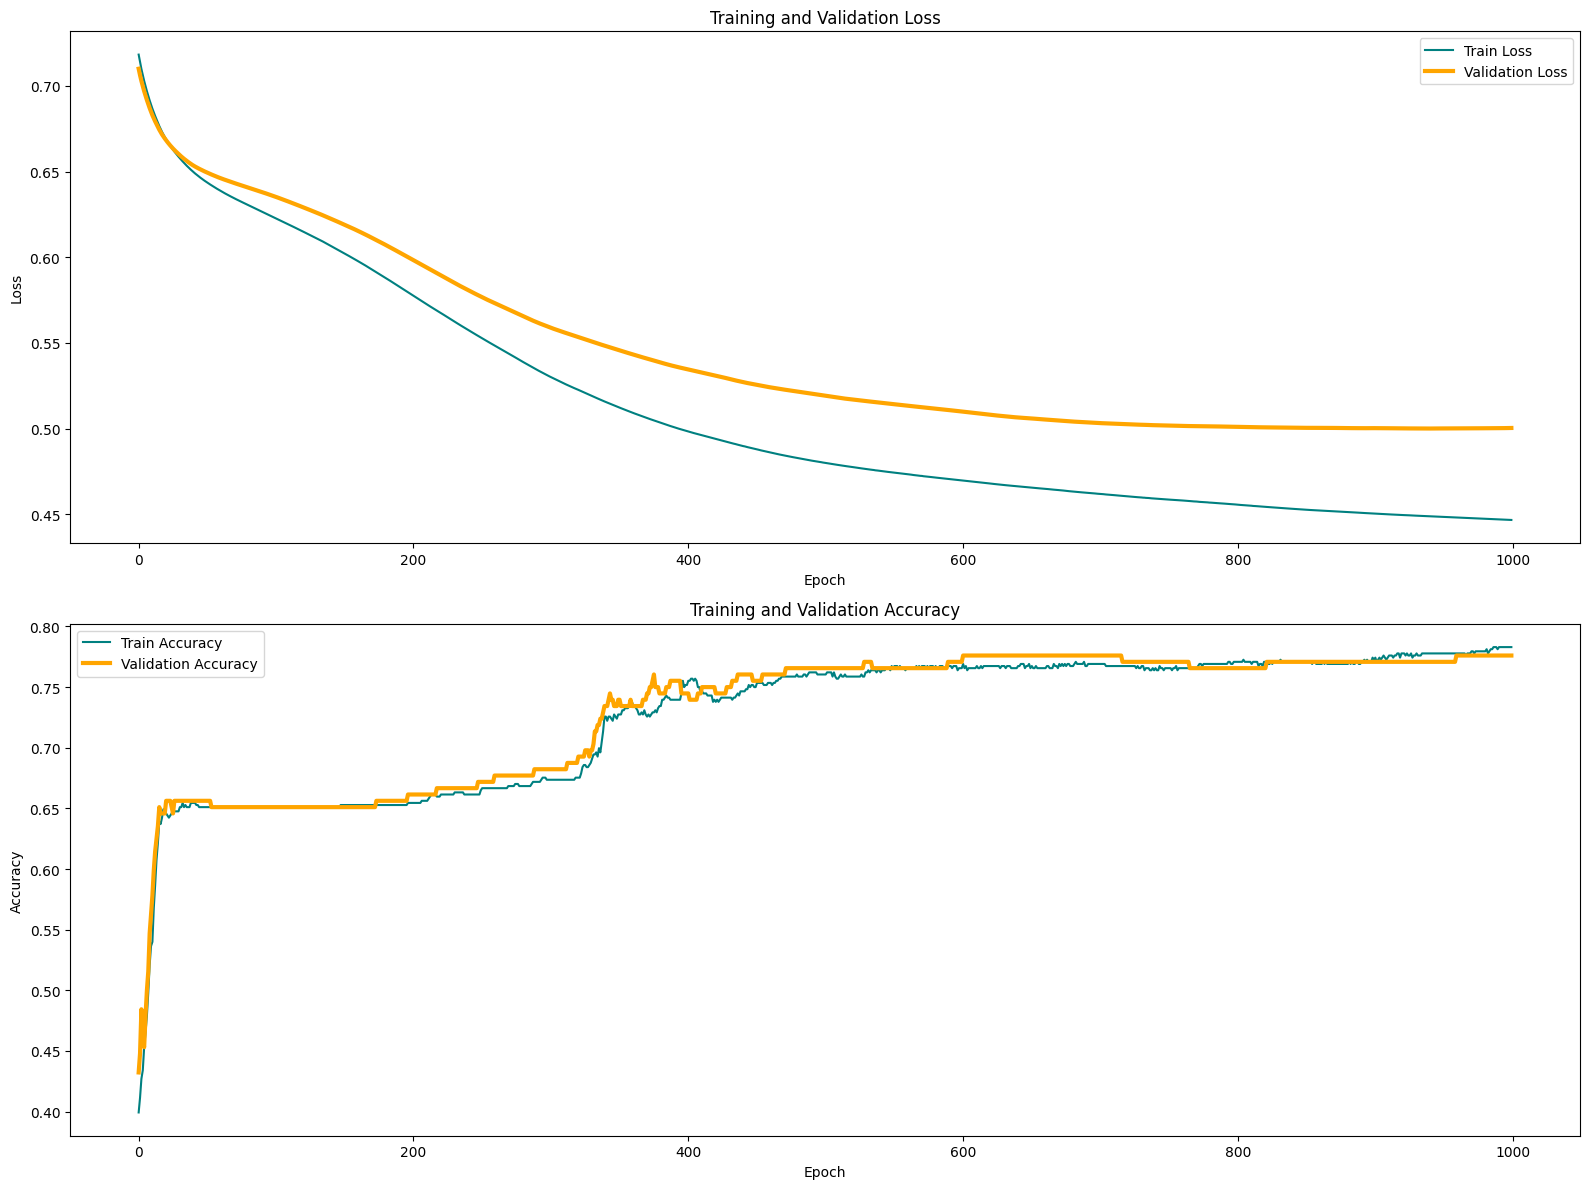

In [169]:
# Plot loss
fig3, (cx1, cx2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
cx1.plot(run_hist_3.history["loss"], 'teal', linestyle='-', label="Train Loss")
cx1.plot(run_hist_3.history["val_loss"], 'orange', linestyle='-', linewidth=3, label="Validation Loss")
cx1.legend()
cx1.set_xlabel("Epoch")
cx1.set_ylabel("Loss")
cx1.set_title("Training and Validation Loss")

# Plot accuracy
cx2.plot(run_hist_3.history["accuracy"], 'teal', linestyle='-', label="Train Accuracy")
cx2.plot(run_hist_3.history["val_accuracy"], 'orange', linestyle='-', linewidth=3, label="Validation Accuracy")
cx2.legend()
cx2.set_xlabel("Epoch")
cx2.set_ylabel("Accuracy")
cx2.set_title("Training and Validation Accuracy")

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()


อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม

    จากการลองปรับค่า Hyperparameter ต่างๆ นิสิตสามารถทำให้โมเดลใหม่นั้นดีขึ้นได้แค่ 
    
    ''' 
        การเพิ่มค่า accuracy ของ validation_accuracy ให้ลู่ใกล้เคียงกับ train_accuracy ใน scale ที่รับได้ คือ 
        Final Training Accuracy: 0.7830
        Final Validation Accuracy: 0.7760
    '''

    โดยนิสิตคิดว่าจาก behavior ของ dataset, sequence model และ SGD optimizer นั้น model จะเริ่มเรียนรู้ได้น้อยลง ( พิจารณาจาก Loss Graph ) ในช่วง epoch ที่ 1000+ โดยมี learning rate = 0.001 และ batch_size = 16 ซึ่งถ้ากำหนดให้ค่าเหล่านี้ไม่ไปในทิศทางเดียวกัน model อาจจะ overfitted ได้

    การปรับ complexity และจำนวนของ layer ของ model, hidden layer = 1 - 3 ให้ผลที่ไม่แตกต่างและมีนัยยะมากนัก

    

## Hyperparameter Tuning Records

### Round 1

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.005
  - Epoch: 1000
  - Batch size: 32

- **Results:**
  - Final Training Loss: 0.3969
  - Final Validation Loss: 0.5624
  - Final Training Accuracy: 0.8212
  - Final Validation Accuracy: 0.7292

### Round 2

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.002
  - Epoch: 2000
  - Batch size: 32

- **Results:**
  - Final Training Loss: 0.4025
  - Final Validation Loss: 0.5439
  - Final Training Accuracy: 0.8125
  - Final Validation Accuracy: 0.7188

### Round 3

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.001
  - Epoch: 2500
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4381
  - Final Validation Loss: 0.5285
  - Final Training Accuracy: 0.7899
  - Final Validation Accuracy: 0.7500

### Round 4

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.001
  - Epoch: 2500
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.3871
  - Final Validation Loss: 0.5369
  - Final Training Accuracy: 0.8056
  - Final Validation Accuracy: 0.7604

### Round 5

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.002
  - Epoch: 2500
  - Batch size: 32

- **Results:**
  - Final Training Loss: 0.4233
  - Final Validation Loss: 0.5160
  - Final Training Accuracy: 0.7830
  - Final Validation Accuracy: 0.7448

### Round 6

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.002
  - Epoch: 2500
  - Batch size: 8

- **Results:**
  - Final Training Loss: 0.3564
  - Final Validation Loss: 0.6900
  - Final Training Accuracy: 0.8299
  - Final Validation Accuracy: 0.7135

### Round 7

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.002
  - Epoch: 3000
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4078
  - Final Validation Loss: 0.5495
  - Final Training Accuracy: 0.7969
  - Final Validation Accuracy: 0.7344

### Round 8

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.001
  - Epoch: 2500
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4205
  - Final Validation Loss: 0.5048
  - Final Training Accuracy: 0.8021
  - Final Validation Accuracy: 0.7396

### Round 9

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.001
  - Epoch: 2500
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4164
  - Final Validation Loss: 0.5273
  - Final Training Accuracy: 0.8212
  - Final Validation Accuracy: 0.7448

### Round 10

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.001
  - Epoch: 3000
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.3975
  - Final Validation Loss: 0.5183
  - Final Training Accuracy: 0.8108
  - Final Validation Accuracy: 0.7708

### Round 11

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.001
  - Epoch: 4000
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.3738
  - Final Validation Loss: 0.5447
  - Final Training Accuracy: 0.7951
  - Final Validation Accuracy: 0.7500

### Round 12

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.001
  - Epoch: 3000
  - Batch size: 16
  - Architecture:
    - Dense(8, input_shape=(num_features,), activation="relu")
    - Dense(8, activation="relu")
    - Dense(8, activation="relu")
    - Dense(1, activation="sigmoid")

- **Results:**
  - Final Training Loss: 0.3921
  - Final Validation Loss: 0.5350
  - Final Training Accuracy: 0.8125
  - Final Validation Accuracy: 0.7344

### Round 13

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.001
  - Epoch: 3000
  - Batch size: 16
  - Architecture:
    - Dense(8, input_shape=(num_features,), activation="relu")
    - Dense(8, activation="relu")
    - Dense(1, activation="sigmoid")

- **Results:**
  - Final Training Loss: 0.4107
  - Final Validation Loss: 0.5171
  - Final Training Accuracy: 0.7969
  - Final Validation Accuracy: 0.7604


### Round 14

- **Configuration:**
  - 2 hidden layers
  - Learning rate: 0.002
  - Epoch: 1000
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4137
  - Final Validation Loss: 0.5277
  - Final Training Accuracy: 0.8038
  - Final Validation Accuracy: 0.7240

### Round 15

- **Configuration:**
  - 3 hidden layers
  - Learning rate: 0.001
  - Epoch: 1000
  - Batch size: 16

- **Results:**
  - Final Training Loss: 0.4467
  - Final Validation Loss: 0.5004
  - Final Training Accuracy: 0.7830
  - Final Validation Accuracy: 0.7760